# Model Quality and Explainability with Watson OpenScale

This notebook should be run in a Watson Studio project, using Default Python 3.6 runtime environment. It requires service credentials and a Cloud API key to access the following Cloud services:
* Watson Machine Learning
* Watson OpenScale

The notebook will configure monitors in OpenScale for the German Credit Risk model. The notebook assumes the model has been created/deployed to Watson Machine Learning and that the subscription has been created in Watson OpenScale.

#### Dependency Setup

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client | tail -n 1

#### Configure Service Credentials

Update the two cells below with your Cloud API Key and your Watson Machine Learning service credentials.

In [2]:
CLOUD_API_KEY = "WRSbGHmNSHvy-tLXNfqRvPhnGFfGfx6aLZnVv05h7PsQ"

In [3]:
WML_CREDENTIALS = {
  "apikey": "Rk2Chr1ij8WCQgMThbYME0-o28aa2nwtrAMH7eMspYJP",
  "iam_apikey_description": "Auto-generated for key 1cbdf600-c774-449f-8d7d-3ab37b1a793f",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/44f657e1cfa9244c30605fcaaa86343a::serviceid:ServiceId-7aa04496-3655-4f42-856e-80957aa89bf6",
  "instance_id": "ead3646b-8ad5-4505-80e7-ff0afafe895b",
  "url": "https://us-south.ml.cloud.ibm.com"
}

#### Model Parameters

__Ensure that the two parameters match the model / deployment you have previously subscribed__

In [4]:
MODEL_NAME = "Spark German Risk Model"
DEPLOYMENT_NAME = "Spark German Risk Deployment"

#### Gather Model Information

In [5]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)
wml_client.repository.list_models()

model_uid = None
wml_models = wml_client.repository.get_details()
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

deployment_uid = None
deployment = None
scoring_url = None
wml_deployments = wml_client.deployments.get_details()
for deployment_in in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment_in['entity']['name']:
        deployment_uid = deployment_in['metadata']['guid']
        scoring_url = deployment_in['entity']['scoring_url']
        deployment = deployment_in
        break

if model_uid is None:
    print("No model ...")
    
if deployment_uid is None:
    print("No Model deployment...")
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))
print("Scoring URL: {}".format(scoring_url))

------------------------------------  -----------------------  ------------------------  ---------
GUID                                  NAME                     CREATED                   FRAMEWORK
e7e5151c-670f-4511-9756-934a0f3ebea3  Spark German Risk Model  2019-11-23T07:04:59.246Z  mllib-2.3
------------------------------------  -----------------------  ------------------------  ---------
Model id: e7e5151c-670f-4511-9756-934a0f3ebea3
Deployment id: 5bea19b8-2ae7-4ce1-8df0-a09148a1485a
Scoring URL: https://us-south.ml.cloud.ibm.com/v3/wml_instances/ead3646b-8ad5-4505-80e7-ff0afafe895b/deployments/5bea19b8-2ae7-4ce1-8df0-a09148a1485a/online


## Quality (Performance) Monitor and Explainability

#### Get Watson OpenScale GUID
Each instance of OpenScale has a unique ID. We can get this value using the Cloud API key specified at the beginning of the notebook.

In [6]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.utils import get_instance_guid
import pandas as pd

wos_client = None
WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print("Watson OpenScale GUID: {}".format(WOS_GUID))

wos_client = APIClient(aios_credentials=WOS_CREDENTIALS)
print("Watson OpenScale Python Client Version: {}".format(wos_client.version))

Watson OpenScale GUID: 0ac203a2-114a-497a-9721-d2dedf99d339
Watson OpenScale Python Client Version: 2.1.19


#### Get subscription

We have previously subscribed Watson OpenScale to our machine learning model. Here we get that subscription.

In [7]:
wos_client.data_mart.subscriptions.list()

subscriptions_uids = wos_client.data_mart.subscriptions.get_uids()
subscription_id = None
for sub in subscriptions_uids:
    if wos_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
        subscription = wos_client.data_mart.subscriptions.get(sub)
        subscription_id = sub
        break
            
if subscription is None:
    print('Subscription not found.')
    
print("Subscription ID: {}".format(subscription_id))

5a11528d-f2ae-4b8f-9f03-08fb90587d1a,Spark German Risk Model,model,ead3646b-8ad5-4505-80e7-ff0afafe895b,2019-11-23T07:07:04.924Z


Subscription ID: 5a11528d-f2ae-4b8f-9f03-08fb90587d1a


### Enable Quality Monitor

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [8]:
import time

time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

#### Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [9]:
from IPython.utils import io
import json

with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json -O additional_feedback_data.json
!ls -lh additional_feedback_data.json

with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
    
subscription.feedback_logging.store(additional_feedback_data['data'])
subscription.feedback_logging.show_table()

-rw-r----- 1 dsxuser dsxuser 17K Nov 23 17:04 additional_feedback_data.json


less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2019-11-23 17:04:33.923558+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2019-11-23 17:04:33.923558+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2019-11-23 17:04:33.923558+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2019-11-23 17:04:33.923558+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2019-11-23 17:04:33.923558+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2019-11-23 17:04:33.923558+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-23 17:04:33.923558+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-23 17:04:33.923558+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2019-11-23 17:04:33.923558+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2019-11-23 17:04:33.923558+00:00


#### Run quality monitor


In [10]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run b6d1cb19-9bbf-4306-a11d-dccb84aaf474 




initializing
completed

---------------------------
 Successfully finished run 
---------------------------




In [11]:
subscription.quality_monitoring.show_table()

2019-11-23 17:04:59.935000+00:00,true_positive_rate,73adac0f-c632-4254-af3b-baac886993cb,0.3939393939393939,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,area_under_roc,73adac0f-c632-4254-af3b-baac886993cb,0.6662004662004662,0.7,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,precision,73adac0f-c632-4254-af3b-baac886993cb,0.7647058823529411,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,f1_measure,73adac0f-c632-4254-af3b-baac886993cb,0.5199999999999999,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,accuracy,73adac0f-c632-4254-af3b-baac886993cb,0.7551020408163265,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,log_loss,73adac0f-c632-4254-af3b-baac886993cb,0.4453043250204494,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,false_positive_rate,73adac0f-c632-4254-af3b-baac886993cb,0.06153846153846154,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,area_under_pr,73adac0f-c632-4254-af3b-baac886993cb,0.6350176434210048,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a
2019-11-23 17:04:59.935000+00:00,recall,73adac0f-c632-4254-af3b-baac886993cb,0.3939393939393939,,,model_type: original,ead3646b-8ad5-4505-80e7-ff0afafe895b,5a11528d-f2ae-4b8f-9f03-08fb90587d1a,5bea19b8-2ae7-4ce1-8df0-a09148a1485a


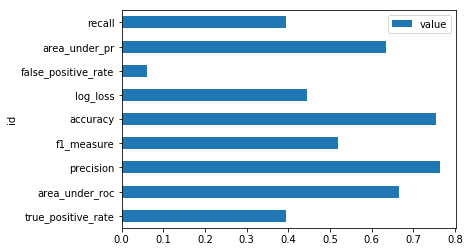

In [12]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [13]:
#wos_client.data_mart.get_deployment_metrics()

### Enable Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [14]:
import pandas as pd
from ibm_ai_openscale.supporting_classes import *

with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv -O german_credit_data_biased_training.csv
!ls -lh german_credit_data_biased_training.csv

pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)

subscription.explainability.enable(training_data=pd_data)
explainability_details = subscription.explainability.get_details()

-rw-r----- 1 dsxuser dsxuser 674K Nov 23 17:05 german_credit_data_biased_training.csv


In [16]:
payload_data = subscription.payload_logging.get_table_content(limit=15)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

#transaction_id = payload_data['scoring_id'].values[0]
#print(transaction_id)
#explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)
#explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
#print(explain_result)
#explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);


,scoring_id,predictedLabel,probability
0,95b030a7cb2d46944e2795a02409f218-5,No Risk,"[0.9817869466967226, 0.01821305330327745]"
1,95b030a7cb2d46944e2795a02409f218-8,No Risk,"[0.8476259694151986, 0.15237403058480137]"
2,95b030a7cb2d46944e2795a02409f218-4,No Risk,"[0.9247650469790445, 0.07523495302095555]"
3,95b030a7cb2d46944e2795a02409f218-3,No Risk,"[0.8281872930859508, 0.17181270691404923]"
4,95b030a7cb2d46944e2795a02409f218-1,No Risk,"[0.7049739820773709, 0.29502601792262906]"
5,95b030a7cb2d46944e2795a02409f218-6,No Risk,"[0.8055984583499919, 0.19440154165000817]"
6,95b030a7cb2d46944e2795a02409f218-2,No Risk,"[0.6193699588344816, 0.3806300411655183]"
7,95b030a7cb2d46944e2795a02409f218-7,Risk,"[0.0796042558779473, 0.9203957441220527]"


## Next steps




__Return to the workshop instruction book.__


## Credits

This notebook was adapted from the following sources:

* [Monitor Models Code Pattern](https://github.com/IBM/monitor-wml-model-with-watson-openscale)
* [OpenScale Labs](https://github.com/pmservice/OpenScale-Labs)
* [OpenScale Tutorials](https://github.com/pmservice/ai-openscale-tutorials)

#### Original Authors
* Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.
* Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.
